# 01 - 3DGS Attribute Analysis & Compression Motivation

3D Gaussian Splatting (3DGS) represents a scene as a large set of 3D Gaussian primitives, each with 59 floating-point attributes:  
- **3D position**,  
- **rotation** (4), **scaling** (3),  
- **opacity** (1),  
- **color** via Spherical Harmonics (48 coefficients: 3×16 for RGB)  

These attributes are stored as 32-bit floats by default. For millions of Gaussians, this results in hundreds of megabytes per scene.

> Goal: Identify which attributes are redundant or low-precision enough to compress, and motivate the use of quantization.



In [3]:
import numpy as np
import matplotlib.pyplot as plt

base_path = "../data/drjohnson/"

means3D = np.load(base_path + "means3D.npy")
opacity = np.load(base_path + "opacity.npy")
rotations = np.load(base_path + "rotations.npy")
scales = np.load(base_path + "scales.npy")
sh = np.load(base_path + "sh.npy")

print("means3D:", means3D.shape)
print("opacity:", opacity.shape)
print("rotations:", rotations.shape)
print("scales:", scales.shape)
print("sh:", sh.shape)

# Plot configuration

plt.rcParams.update({
    "font.size": 12,
    "font.weight": "bold",           # 全局加粗
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "axes.labelweight": "bold",      # 坐标轴标题加粗
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "xtick.major.width": 0,        # 可以加粗刻度线
    "ytick.major.width": 0,
    "xtick.direction": "inout",
    "ytick.direction": "inout",
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
})


means3D: (3405153, 3)
opacity: (3405153, 1)
rotations: (3405153, 4)
scales: (3405153, 3)
sh: (3405153, 16, 3)


## 1. Value Distribution Analysis

Following Figure 1 in [3DGS.zip], we first plot histograms for `opacity` and the first component of `scale`. These distributions help us determine which Gaussians are potentially irrelevant or redundant.

- Low `opacity` → candidates for pruning  
- Narrow `SH` / `scale` range → candidates for low-bit quantization


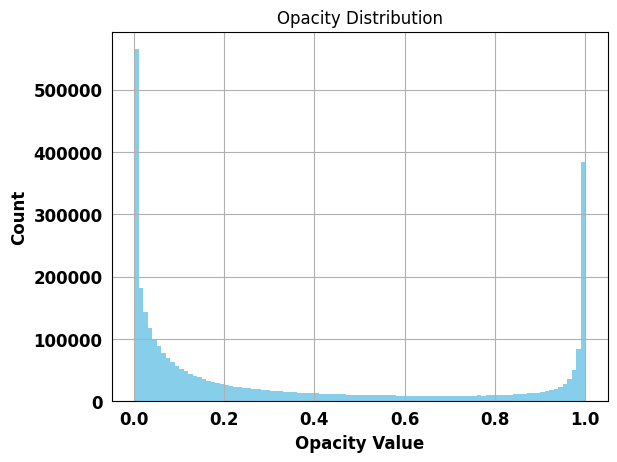

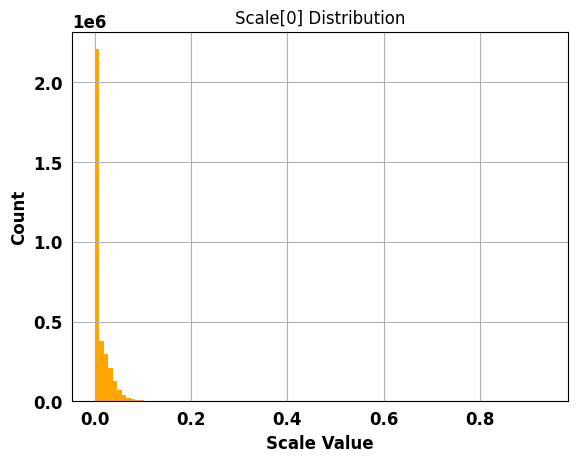

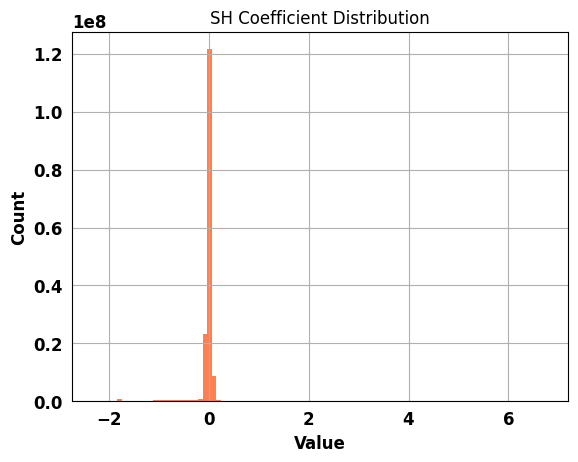

In [5]:
# Opacity 分布
plt.hist(opacity, bins=100, color='skyblue')
plt.title("Opacity Distribution")
plt.xlabel("Opacity Value")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Scale 分布（取第一个轴）
plt.hist(scales[:, 0], bins=100, color='orange')
plt.title("Scale[0] Distribution")
plt.xlabel("Scale Value")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# SH 系数分布
plt.hist(sh.flatten(), bins=100, color='coral')
plt.title("SH Coefficient Distribution")
plt.xlabel("Value")
plt.ylabel("Count")
plt.grid(True)
plt.show()


## 2. Insights from Distributions

From the above analysis:

- A large number of Gaussians have **opacity ≈ 0**, suggesting they contribute little to the final image. These can be pruned.
- Most SH coefficients and scale values lie within **[-0.5, 0.5]** or even tighter ranges.
- This suggests **linear quantization** with 8-bit or even 6-bit may preserve sufficient detail.

These findings motivate:
1. **Pruning** low-opacity Gaussians
2. **Uniform Quantization** of SH, scale, rotation to reduce memory
3. Further exploration of **attribute correlation** (see Figure 2 in the paper)


In [6]:
def stats(name, arr):
    print(f"{name:<10s} | min: {arr.min():.4f}, max: {arr.max():.4f}, std: {arr.std():.4f}")

stats("Opacity", opacity)
stats("Scale-0", scales[:, 0])
stats("SH", sh)


Opacity    | min: 0.0006, max: 1.0000, std: 0.3823
Scale-0    | min: 0.0000, max: 0.9353, std: 0.0196
SH         | min: -2.2930, max: 6.7475, std: 0.2674


attr_mat shape: (3405153, 14)


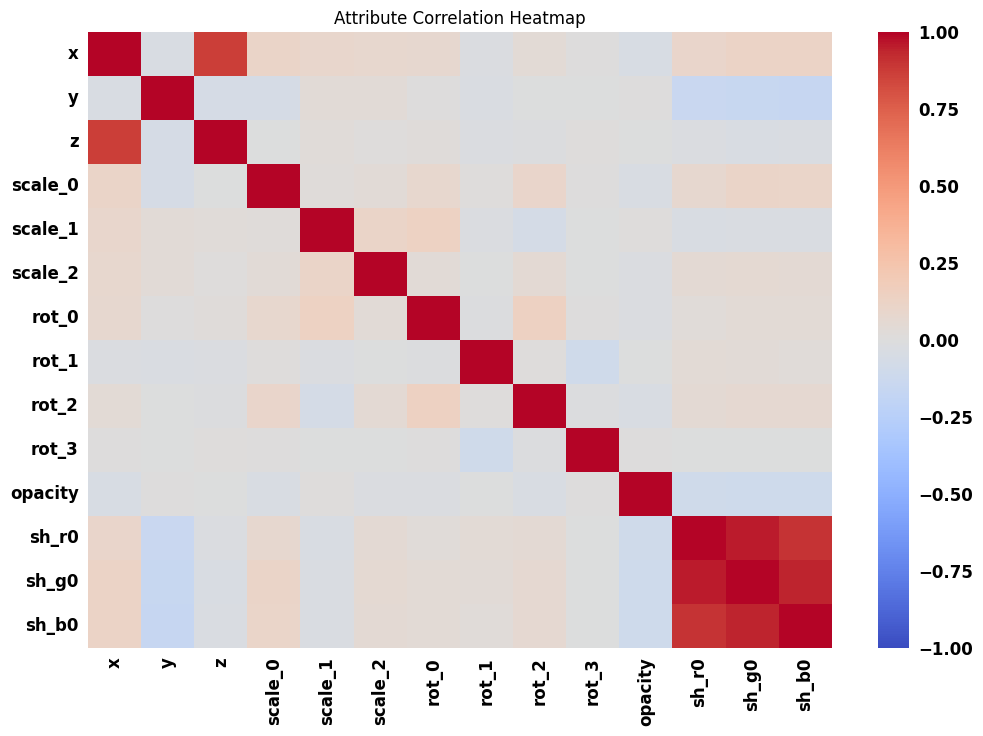

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 1) 提取 degree-0 SH 基础色 (N,3)
sh_dc = sh[:, 0, :]    # RGB 第0阶

# 2) 确保 opacity 是 (N,1)
opacity = opacity.reshape(-1, 1)

# 3) 拼接所有属性为 (N, 14)
attr_mat = np.hstack([
    means3D,         # (N, 3)
    scales,          # (N, 3)
    rotations,       # (N, 4)
    opacity,         # (N, 1)
    sh_dc            # (N, 3)
])

# 确认形状
print("attr_mat shape:", attr_mat.shape)  # 应该是 (3405153, 14)

# 4) 构造 DataFrame
columns = [
    "x","y","z",
    "scale_0","scale_1","scale_2",
    "rot_0","rot_1","rot_2","rot_3",
    "opacity",
    "sh_r0","sh_g0","sh_b0"
]
df = pd.DataFrame(attr_mat, columns=columns)

# 5) 画相关性热力图
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=False)
plt.title("Attribute Correlation Heatmap")
plt.show()


关键属性分布可视化：

opacity 的分布呈现出大量接近零的高斯点，说明其中一部分几乎不参与最终图像生成，可作为剪枝候选。

scale 和 SH 的值分布集中，波动范围小，说明其在不损失可感知质量的情况下具有低比特表示的潜力。

属性间相关性分析：

借助相关性热力图发现：SH 各通道之间相关性高，rotation 各分量之间也具有耦合性。

这提示我们可以考虑使用联合量化或低秩编码对相关属性进行进一步压缩。

下面是 3dgs.zip 之外的分析

### 1.1 空间密度与区域差异

**为什么做？**  
3DGS 中的 Gaussian 在空间上分布并不均匀，有的区域非常密集，有的区域很稀疏。  
- **密集区**：冗余高，可考虑更加激进的剪枝或分簇编码  
- **稀疏区**：信息量大，可采用保守的量化策略  

**这个实验能说明：**  
- 每个体素（Voxel）内高斯数量的分布情况  
- 是否存在少数超密集或超稀疏的空间块  
- 后续可针对不同体素设置不同压缩强度


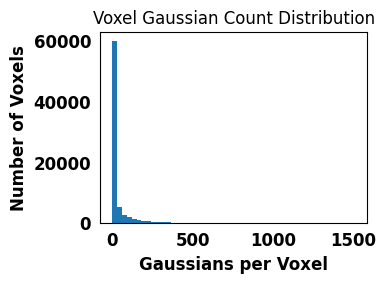

1512


In [ ]:
# 1. 空间密度统计
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 假设 means3D 已经加载，shape=(N,3)
points = means3D  

# 体素大小（可根据场景尺度调整）
voxel_size = 0.1  
coords = np.floor(points / voxel_size).astype(int)

# 统计每个体素的高斯数量
counts = np.array(list(Counter(map(tuple, coords)).values()))

# 可视化直方图
plt.figure(figsize=(4,3))
plt.hist(counts, bins=50)
plt.title("Voxel Gaussian Count Distribution")
plt.xlabel("Gaussians per Voxel")
plt.ylabel("Number of Voxels")
plt.tight_layout()
plt.show()


**空间感知剪枝与压缩策略?**

**大多数体素非常稀疏**  
   - 绝大多数体素中只包含很少的 Gaussians（<20 个），甚至是个位数。
   - 说明 3DGS 的点云分布存在广泛的“稀疏区域”，这些区域可能对应的是背景、空洞或低纹理区。

### 1.2 深度分层分析

**为什么做？**  
不同深度（远近）处的 Gaussians 对最终渲染质量的敏感度不同：  
- 近处点：像素贡献大，需要更高精度  
- 远处点：像素贡献小，可更激进压缩  

**这个实验能说明：**  
- `opacity` 和 `scale` 随深度的均值与方差变化趋势  
- 是否可以对远近分别设计不同量化或剪枝策略


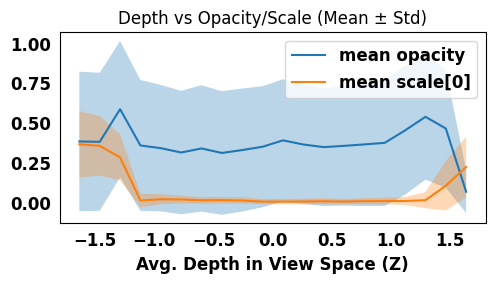

In [5]:
import numpy as np
import matplotlib.pyplot as plt

view_matrices = np.load("/data/peiminnan/3DGS-Quantization-Study/data/drjohnson/view_matrices.npy")  # (M, 4, 4)

# ✅ 使用某一帧的 view matrix，或遍历多帧求平均深度也可
viewmatrix = view_matrices[0]  # 选第0帧

# 深度计算函数
def calculate_depths(means3D, viewmatrix):
    means_homo = np.concatenate([means3D, np.ones((means3D.shape[0], 1))], axis=1)  # (N, 4)
    means_view = means_homo @ viewmatrix.T                                         # (N, 4)
    return means_view[:, 2]

# 每隔10帧采样
sampled_indices = np.arange(0, len(view_matrices), 10)
depths_all = []

for idx in sampled_indices:
    depths_i = calculate_depths(means3D, view_matrices[idx])
    depths_all.append(depths_i)

depths_all = np.stack(depths_all, axis=1)  # (N, num_sampled_views)
depths = np.mean(depths_all, axis=1)       # (N,) 平均深度

# 分 bin 可视化分析
op = opacity.flatten()
sc0 = scales[:, 0]

bins = np.linspace(depths.min(), depths.max(), 21)
inds = np.digitize(depths, bins)

means_op = [op[inds == i].mean() if np.any(inds == i) else 0 for i in range(1, len(bins))]
stds_op  = [op[inds == i].std()  if np.any(inds == i) else 0 for i in range(1, len(bins))]
means_sc = [sc0[inds == i].mean() if np.any(inds == i) else 0 for i in range(1, len(bins))]
stds_sc  = [sc0[inds == i].std()  if np.any(inds == i) else 0 for i in range(1, len(bins))]
centers  = (bins[:-1] + bins[1:]) / 2

# 绘图
plt.figure(figsize=(5, 3))
plt.plot(centers, means_op, label='mean opacity')
plt.fill_between(centers, np.array(means_op) - np.array(stds_op), np.array(means_op) + np.array(stds_op), alpha=0.3)
plt.plot(centers, means_sc, label='mean scale[0]')
plt.fill_between(centers, np.array(means_sc) - np.array(stds_sc), np.array(means_sc) + np.array(stds_sc), alpha=0.3)
plt.xlabel("Avg. Depth in View Space (Z)")
plt.title("Depth vs Opacity/Scale (Mean ± Std)")
plt.legend()
plt.tight_layout()
plt.show()


说明当前数据集下这些值与深度关系不大，不用做后续分析。

### 1.3 PCA 降维与主成分贡献

**为什么做？**  
如果 SH 或其它高维属性在低维主成分空间已有高度可表达性，  
可用低秩（PCA）或联合量化替代逐通道量化，提升压缩效率。  

**这个实验能说明：**  
- 前 k 个主成分能解释的方差比例  
- 是否只保留前 2~3 个成分即可近似重构 SH


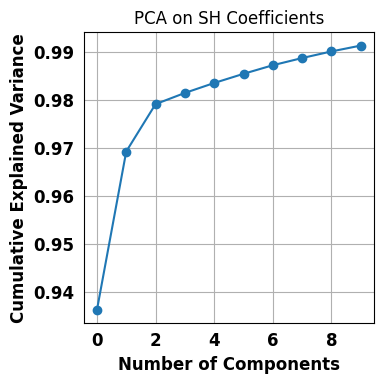

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 将 SH 展平为 (N, 16*3) 矩阵
sh_flat = sh.reshape(len(sh), -1)

# 用 PCA 分析前 10 个成分
pca = PCA(n_components=10)
pca.fit(sh_flat)
var_ratio = pca.explained_variance_ratio_

# 绘制累积方差
plt.figure(figsize=(4,4))
plt.plot(np.cumsum(var_ratio), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA on SH Coefficients")
plt.grid(True)
plt.tight_layout()
plt.show()


**前两个主成分即可解释超过 97% 的总方差**  
- 表明 SH 向量在高维空间中呈现出非常强的低秩结构；
- 说明大部分信息可以被嵌入在一个低维子空间中表达。

### 1.4 四元数分布检查

**为什么做？**  
3DGS 用四元数表示旋转，理论上‖q‖≈1。  
- 如果有偏离，可考虑重新正则化或量化时保证单位长度  
- 如果分量变化小，可考虑降低比特深度

**这个实验能说明：**  
- 四元数范数分布是否集中在 1 附近  
- 各分量的变动范围


rotations shape: (3405153, 4)


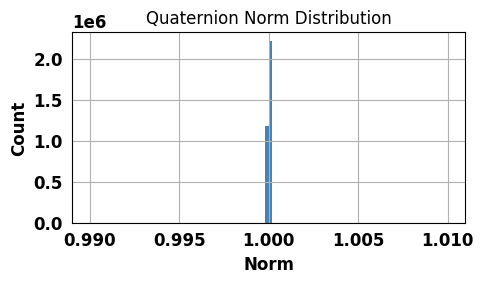

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 计算四元数范数
qnorm = np.linalg.norm(rotations, axis=1)

plt.figure(figsize=(5,3))
plt.hist(qnorm, bins=100, range=(0.99, 1.01), color='steelblue')
plt.title("Quaternion Norm Distribution")
plt.xlabel("Norm")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


常规 float→int 线性量化在单位四元数上表现不佳，可以考虑更结构化的量化方式。

### 1.5 尺度各向异性分析

**为什么做？**  
如果大多数高斯近似球形（各向同性），即可只保留单一尺度值；  
如果扁平/细长，需保留 3 个方向尺度。  

**这个实验能说明：**  
- `scale_x/scale_y` 和 `scale_x/scale_z` 的分布  
- 是否存在明显的各向异性


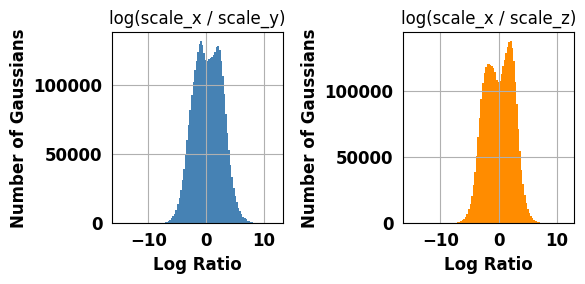

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 为避免除0和负数，加一个小值；并剔除非法值（如负数）
eps = 1e-6
valid = (scales[:,1] > eps) & (scales[:,2] > eps)
r_xy = np.log(scales[valid, 0] / scales[valid, 1])
r_xz = np.log(scales[valid, 0] / scales[valid, 2])

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.hist(r_xy, bins=100, color='steelblue')
plt.title("log(scale_x / scale_y)")
plt.xlabel("Log Ratio")
plt.ylabel("Number of Gaussians")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(r_xz, bins=100, color='darkorange')
plt.title("log(scale_x / scale_z)")
plt.xlabel("Log Ratio")
plt.ylabel("Number of Gaussians")
plt.grid(True)

plt.tight_layout()
plt.show()


各向异性有但不明显。

### 1.6 最近邻距离分布

空间冗余高的区域（NN 距离小）可考虑更激进剪枝或分组编码，  
稀疏区域（NN 距离大）需要保守策略。  

**这个实验能说明：**  
- 高斯点云的局部密度分布  
- 可根据 NN 距离设定局部剪枝阈值


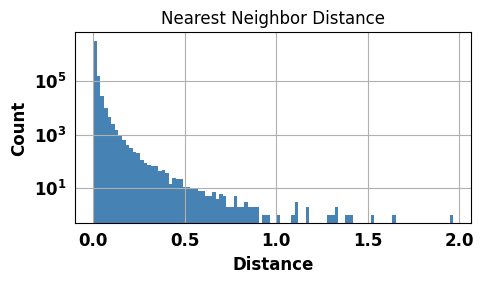

In [18]:
from sklearn.neighbors import KDTree
import numpy as np
import matplotlib.pyplot as plt

# 建树并找最近邻
tree = KDTree(means3D, leaf_size=40)
dist, _ = tree.query(means3D, k=2)
nn_dist = dist[:,1]

plt.figure(figsize=(5,3))
plt.hist(nn_dist, bins=100, color='steelblue')
plt.title("Nearest Neighbor Distance")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.yscale("log")  # ✅ 关键：使用对数尺度
plt.grid(True)
plt.tight_layout()
plt.show()



结合1.1的分析可以做空间冗余度剪枝，结合高频空间位置且透明度较低两个指标。

### 1.7 影响力（Influence）预估

**为什么做？**  
可用 `opacity × 体素体积(≈scale_x·scale_y·scale_z)` 估算每个高斯对图像的潜在贡献。  
- 高影响力点优先保留  
- 低影响力点可优先剪枝  

**这个实验能说明：**  
- 高斯影响力分布  
- 可为后续剪枝提供初步阈值


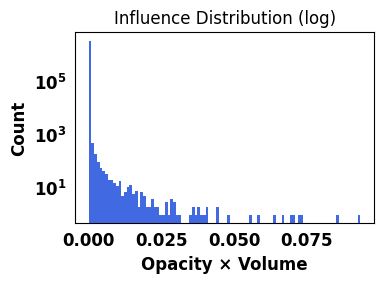

In [19]:
import numpy as np
import matplotlib.pyplot as plt

volumes = scales[:,0] * scales[:,1] * scales[:,2]
influence = opacity.flatten() * volumes

plt.figure(figsize=(4,3))
plt.hist(influence, bins=100, log=True, color='royalblue')
plt.title("Influence Distribution (log)")
plt.xlabel("Opacity × Volume")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


有很多高斯影响力很低。但是目前的实验很初步，可能还需要结合颜色浓度来分析。

### 1.8 颜色聚类（SH 向量）

**为什么做？**  
对 SH 向量进行聚类可以发现主色簇，  
- 为向量量化（VQ）或 codebook 设计提供先验  
- 聚焦于高频或特殊颜色区域

**这个实验能说明：**  
- SH 分布中的主要聚类中心及其占比  
- 聚类结果可作为 codebook 的初始化


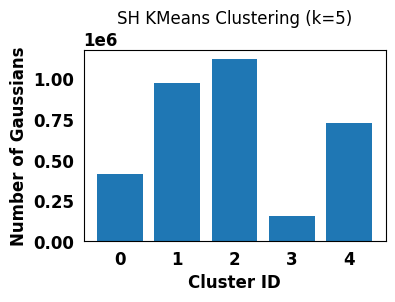

In [24]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# SH 展平
sh_flat = sh.reshape(len(sh), -1)

# KMeans 聚类（示例 k=5）
kmeans = KMeans(n_clusters=5, random_state=0).fit(sh_flat)
labels, counts = np.unique(kmeans.labels_, return_counts=True)

plt.figure(figsize=(4,3))
plt.bar(labels, counts)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Gaussians")
plt.title("SH KMeans Clustering (k=5)")
plt.tight_layout()
plt.show()


没有什么可以剪掉的低频簇。

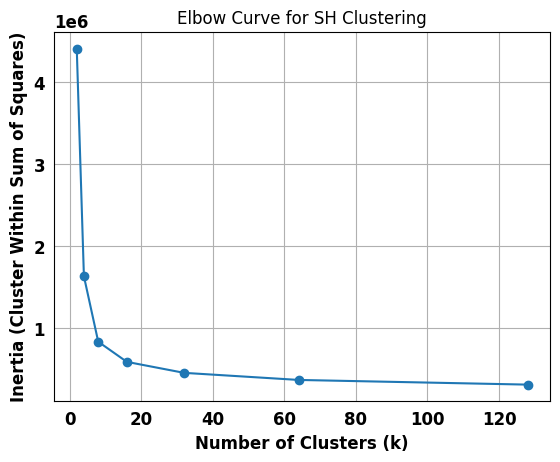

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = [2, 4, 8, 16, 32, 64, 128]
for k in K_range:
    km = KMeans(n_clusters=k, random_state=0).fit(sh_flat)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Cluster Within Sum of Squares)")
plt.title("Elbow Curve for SH Clustering")
plt.grid(True)
plt.show()


肘部位置大致出现在 $k=16 \sim 32$，这意味着在此范围内的聚类数可兼顾表达能力与压缩率，构建码本的时候可以考虑。

### 1.9 属性–深度散点图

**为什么做？**  
直观查看属性（如 `opacity`、`scale`）随深度的离散情况，  
- 判断深度对属性波动的影响  
- 指导分层量化设计

**这个实验能说明：**  
- 深度 vs 属性的整体趋势与离群点  
- 可视化异常区域


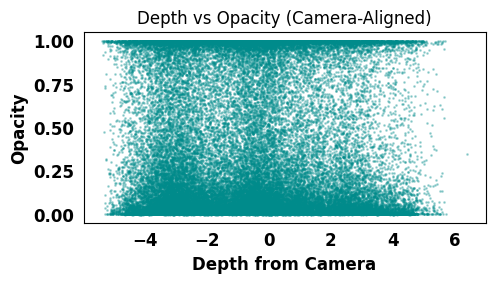

In [21]:
def calculate_depths(means3D, viewmatrix):
    means_homo = np.concatenate([means3D, np.ones((means3D.shape[0], 1))], axis=1)  # (N, 4)
    means_view = means_homo @ viewmatrix.T                                         # (N, 4)
    return means_view[:, 2]  # Z in camera space

import numpy as np
import matplotlib.pyplot as plt

# ✅ 使用更合理的深度定义（相对于第一个相机视角）
viewmatrix = view_matrices[0]  # shape: (4, 4)
depths = calculate_depths(means3D, viewmatrix)
op = opacity.flatten()

# 为了可视化下采样
idx = np.random.choice(len(depths), size=50000, replace=False)

plt.figure(figsize=(5,3))
plt.scatter(depths[idx], op[idx], s=1, alpha=0.3, c='darkcyan')
plt.xlabel("Depth from Camera")
plt.ylabel("Opacity")
plt.title("Depth vs Opacity (Camera-Aligned)")
plt.tight_layout()
plt.show()



- 深度小但 opacity 低的点 → 可能是边缘冗余高斯；
- 深度大但 opacity 高的点 → 可考虑近似合并处理。

### 1.10 属性–空间平面热力图

**为什么做？**  
将属性映射到水平平面（X–Y）上，  
- 直观查看屏幕空间中哪些区域属性值高/低  
- 为区域性压缩、分块量化或剪枝提供直观指导

**这个实验能说明：**  
- 空间分布中属性值的热点区域  
- 可结合图像分块做分区压缩


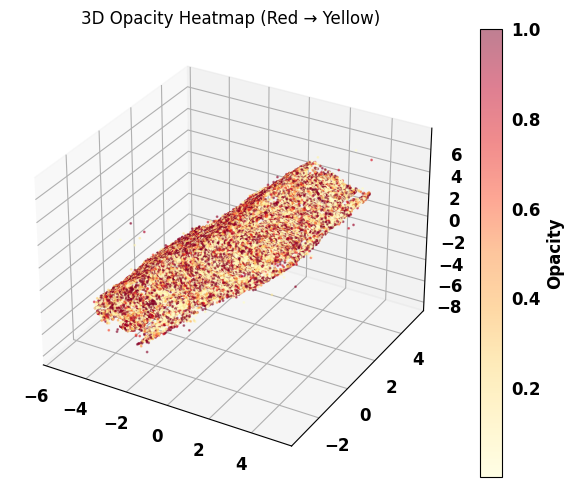

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

# 属性选择
attr = opacity.flatten()
idx = np.random.choice(len(attr), size=100000, replace=False)

# 使用红到黄色图 'autumn' 或 'YlOrRd'
p = ax.scatter(means3D[idx, 0], means3D[idx, 1], means3D[idx, 2],
               c=attr[idx], cmap='YlOrRd', s=1, alpha=0.5)

ax.set_title("3D Opacity Heatmap (Red → Yellow)")
fig.colorbar(p, ax=ax, label="Opacity")
plt.tight_layout()
plt.show()



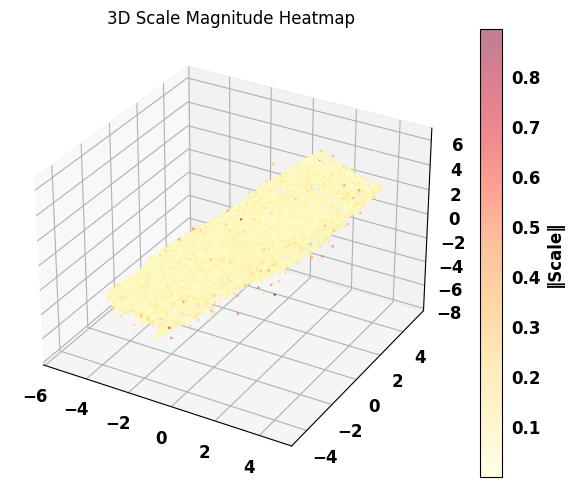

In [29]:
scale_norm = np.linalg.norm(scales, axis=1)  # 代表空间尺寸影响力

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

idx = np.random.choice(len(scale_norm), size=100000, replace=False)
p = ax.scatter(means3D[idx, 0], means3D[idx, 1], means3D[idx, 2],
               c=scale_norm[idx], cmap='YlOrRd', s=1, alpha=0.5)
ax.set_title("3D Scale Magnitude Heatmap")
fig.colorbar(p, ax=ax, label="‖Scale‖")
plt.tight_layout()
plt.show()


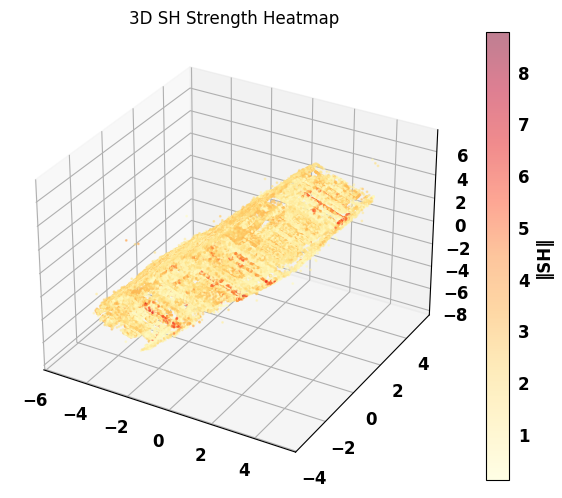

In [30]:
sh_strength = np.linalg.norm(sh.reshape(len(sh), -1), axis=1)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

idx = np.random.choice(len(sh_strength), size=100000, replace=False)
p = ax.scatter(means3D[idx, 0], means3D[idx, 1], means3D[idx, 2],
               c=sh_strength[idx], cmap='YlOrRd', s=1, alpha=0.5)
ax.set_title("3D SH Strength Heatmap")
fig.colorbar(p, ax=ax, label="‖SH‖")
plt.tight_layout()
plt.show()


空间分布没有什么特点。